# Extracting the top reddits according to several metrics

In [1]:
# let's fetch statistics about sub-redits
from urllib.request import urlopen
import json
import re
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
import requests
import numpy as np
from sklearn import preprocessing
import time
URL = 'https://subredditstats.com/'

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
DRIVER_PATH = '/path/to/chromedriver'
driver = webdriver.Chrome(executable_path=DRIVER_PATH)

options = Options()
options.headless = True
options.add_experimental_option("detach", True)
driver = webdriver.Chrome(options=options, executable_path=DRIVER_PATH)
driver.get("https://subredditstats.com/")

C:\Users\bouab\AppData\Local\Temp\ipykernel_14388\61335477.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=DRIVER_PATH)
C:\Users\bouab\AppData\Local\Temp\ipykernel_14388\61335477.py:7: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  options.headless = True
C:\Users\bouab\AppData\Local\Temp\ipykernel_14388\61335477.py:9: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(options=options, executable_path=DRIVER_PATH)


In [3]:
from time import sleep
from selenium.webdriver.remote.webelement import WebElement
from selenium.webdriver.common.by import By
import re
from typing import Union
from pathlib import Path
import os
import random
import pandas as pd

from unidecode import unidecode

REGEX = r'[!\"#\$&\*\+,\.\/:;<=>\?@\[\\\]\^`{\|}~]+'


def extract_metric(subreddit_list_element: WebElement, num_loading: int=1, 
                   min_loading_pause: float=0.5, max_loading_pause: float=1.5,  
                   debug:bool=False, save_path:Union[str, Path]=None, wait:int=5):

    # set the driver to wait for a certain number of seconds
    if wait:
        driver.implicitly_wait(wait)

    # first extract the name of the list
    list_name = subreddit_list_element.find_element(By.CLASS_NAME, 'header-area').find_element(By.CLASS_NAME, 'list-title').text
    # clean the rest name if needed

    list_name = re.sub(REGEX , '', list_name.strip())

    list_name = "_".join(list_name.split())

    # before proceeding further let's load more data for each list: 100 items per list should be enough for now
    # extract the load more button element
    list_footer = subreddit_list_element.find_element(By.CLASS_NAME, 'footer-area')
    

    for i in range(num_loading):
        # in list_footer, find the load more button
        list_footer.find_element(By.TAG_NAME, 'button').click()
        # randomize the time the waiting time between the given bounds
        # to simulate the human bahavior and minimize the chances of getting blocked
        wait_time = random.uniform(min_loading_pause, max_loading_pause)
        sleep(wait_time)

    # now I am supposed to once to find the l
    items = subreddit_list_element.find_elements(By.CLASS_NAME, 'subreddit-list-item')

    # assert   (num_loading  + 1) * 50 >= len(items) >= (num_loading) * 50 

    # first extract the meaning associated with each item
    # in the sub-reddit list, extract both the header of the table and the body
    table_header = subreddit_list_element.find_element(By.CLASS_NAME, 'block-table').find_element(By.TAG_NAME, 'thead')
    table_body = subreddit_list_element.find_element(By.CLASS_NAME, 'block-table').find_element(By.TAG_NAME, 'tbody')

    metric_name = table_header.find_elements(By.TAG_NAME, 'tr')[-1].text
    # process the metric name for completeness
    metric_name = re.sub(REGEX, '', metric_name.strip())
    metric_name = "_".join(metric_name.split())
    
    items = table_body.find_elements(By.CLASS_NAME, 'subreddit-list-item')

    if debug: 
        print(f"THE LIST'S NAME: {list_name}")
        print(f"THE METRIC'S NAME: {metric_name}")
        print(f"THE NUMBER OF ITEMS FOR THE CURRENT LIST: {len(items)}")
        print("displaying scraped results: ")
        # let's extract the items then
        for i in items[:3]:
            sub_reddit_name = i.get_attribute('data-subreddit-name')
            metric_value = i.find_elements(By.TAG_NAME, 'td')[-1].text
            # extract the last one
            print(f'The sub reddit {sub_reddit_name}: {metric_name}: {metric_value}')

    # first set the parameters to save the scrapped data at the local file system
    if save_path is not None:
        save_path =  os.path.join(os.getcwd(), save_path) if os.path.abspath(save_path) else save_path

        # attempt to create a directory 
        try:
            os.makedirs(save_path, exist_ok=True)
        except ValueError: # in case the passed path is indeed a file
            pass
        
        if not os.path.isfile(save_path):
            save_path = os.path.join(save_path, f'{list_name}.csv')

    else:    
        save_path = os.path.join(os.getcwd(), f'{list_name}.csv')

    # time to extract the results    
    results = [(i.get_attribute('data-subreddit-name'), i.find_elements(By.TAG_NAME, 'td')[-1].text) for i in items] 
    names, metrics = list(map(list, zip(*results))) 
    # make sure to convert each string to its ascii representation

    names, metrics = [unidecode(n) for n in names], [unidecode(m) for m in metrics]

    # create the datafrmae
    data = pd.DataFrame({"subreddit": names, f'{list_name}_{metric_name}':metrics})
    
    # make sure to save the file
    data.to_csv(save_path, index=False)
    return data



In [4]:
from time import sleep
from selenium.webdriver.common.by import By
from _collections_abc import Sequence

def scrap_reddit_stats_home_page(driver: webdriver, num_loading: int=1, 
                   min_loading_pause: float=0.5, max_loading_pause: float=1.5,  
                   debug:bool=False, save_paths:Union[str, Path, list]=None):


    subreddits = driver.find_elements(By.CLASS_NAME, 'subreddit-list')

    # adjust the path files according to the sub reddits extracted
    if not (isinstance(save_paths, Sequence) and save_paths is None):
        save_paths = [save_paths for _ in subreddits]
    elif save_paths is None:
        save_paths = []

    # in case the save_paths are more than the subreddits
    save_paths = save_paths[:len(subreddits)]
    
    # append None at the end for default local sytems
    save_paths += [None for _ in range(len(subreddits) - len(save_paths))]
    
    # extract the data for each list in the home page
    for s, path in zip(subreddits, save_paths):
        extract_metric(s, num_loading=num_loading, min_loading_pause=min_loading_pause, max_loading_pause=max_loading_pause, debug=debug, save_path=path)
        sleep(10)    

In [5]:
DATA_PATH  = os.path.join(os.getcwd(), 'data')
if not os.path.isdir(DATA_PATH):
    scrap_reddit_stats_home_page(driver,num_loading=9, debug=False, save_paths='DATA_PATH')
driver.quit()

# Extracting metrics for a given subreddit

In [6]:
URL = 'https://subredditstats.com/'
driver = webdriver.Chrome(executable_path=DRIVER_PATH)
options = Options()
options.add_experimental_option("detach", True)
options.headless = True
driver = webdriver.Chrome(options=options, executable_path=DRIVER_PATH)


C:\Users\bouab\AppData\Local\Temp\ipykernel_14388\603998357.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=DRIVER_PATH)
C:\Users\bouab\AppData\Local\Temp\ipykernel_14388\603998357.py:5: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  options.headless = True
C:\Users\bouab\AppData\Local\Temp\ipykernel_14388\603998357.py:6: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(options=options, executable_path=DRIVER_PATH)


In [7]:
def from_stats_block(stats_block: WebElement, ):
    table_wrapper = stats_block.find_element(By.TAG_NAME, 'tbody')
    results = table_wrapper.find_elements(By.TAG_NAME, 'tr')
    assert len(results) == 2
    # the first element is the header
    header, statistics = results
    metric_name, _ = [element.text for element in header.find_elements(By.TAG_NAME, 'td')]
    metric_value, rank_value = [element.text for element in statistics.find_elements(By.TAG_NAME, 'td')]
    
    # convert everything to unicode if needed
    metric_name = "_".join(unidecode(metric_name).split(" "))
    metric_value = "_".join(unidecode(metric_value).split(" "))
    rank_value = "_".join(unidecode(rank_value).split())
    
    return {metric_name.lower() + "_number": metric_value, metric_name.lower() + "_rank": rank_value}


def scrap_reddits_stats_specific_page(driver: webdriver, page_name: str, wait:int=None):

    # set the driver to wait for a certain number of seconds
    if wait:
        driver.implicitly_wait(wait)
        
    # first create the url
    sub_reddit_url = f'{URL}r/{page_name.lower().strip()}'
        
    # get to the page in question
    driver.get(sub_reddit_url)

    try:    
        # fetch the statistics block
        header = driver.find_elements(By.CLASS_NAME, 'header')[0]

        statistics_container = header.find_elements(By.CLASS_NAME, 'stat-blocks')[0]
        # extract the blocks with the actual statistics
        
        statistics_blocks = statistics_container.find_elements(By.CLASS_NAME, 'block')
        # iterate through each block to extract the statistics
    except Exception as e:
        print(f"scapping data for subreddit {page_name} raised an error")
        print(e)
        return {}
    
    results = {}

    for s_block in statistics_blocks:
        results.update(from_stats_block(s_block))
    
    if len(results) == 0:
        print(f"scrapping for {page_name} failed !!") 
        return {}

    # add the subreddit name to the dictionary
    results['subreddit'] = page_name
    return results



In [8]:
SUB_REDDIT = 'subreddit'

def build_metrics_dataframe(subreddits: list[str], important_metrics: list[str], limit:int=None, wait:int=20):
    # extract the stats of each subreddits in the data file
    temp_dicts = [scrap_reddits_stats_specific_page(driver, sub, wait=wait) for sub in subreddits[: (limit if limit else -1)]]
    # eliminate subreddits without the full set of important metrics
    temp_dicts = [d for d in temp_dicts if set(important_metrics).issubset(set(d.keys()))]    

    # create a dataframe with the results needed
    df_dict = dict([(key, [d[key] for d in temp_dicts]) for key in important_metrics])
    df = pd.DataFrame(data=df_dict)
    
    try:
        # time to clean all the values: as the values are extracted as strings, they should be cleaned to be correctly converted into numerical values
        df_num = df.copy()

        for num_col in df.columns:
            if num_col != SUB_REDDIT:
                # make sure to remove the unnecessary 
                df_num[num_col] = df_num[num_col].map(lambda x: re.sub('[^\d.]+', '', x)).astype(np.number) # remove any non-numerical characters except for the point '.' (for floating point values)

    except Exception as e:
        print(e)
        return df
    
    return df_num


In [9]:
def top_subreddits_metrics(data_path: str, important_metrics: list[str], limit:int=None, wait:int=20):
    assert SUB_REDDIT in important_metrics
    top_subreddits_df = pd.read_csv(data_path)
    # extract the list of subreddits
    top_subreddits = top_subreddits_df[SUB_REDDIT].tolist()
    return build_metrics_dataframe(top_subreddits, important_metrics, limit, wait)


## Metrics of subreddits with the most comments 

In [10]:
METRICS = ['subreddit', 'subscribers_number', 'subscribers_rank', 'post_votes_number', 'post_votes_rank', 
                   'comments_number', 'comments_rank','comments_per_subscriber_rank', 
                   'comments_per_subscriber_number', 'posts_per_subscriber_rank', 'posts_per_subscriber_number']


The main idea is as follows:
1. For the comments files: we will extract the subreddits with the most comments, extract their ranks in post_votes, subscribers, post_per_subscriber, using the functions described above
2. For the subscribers, growth_year / month, posts_per_Subsivers and post votes, we will inspect their rank in the number of comments and comments per subscribers

In [11]:
# as the files we are interested in are likely to have several subreddits in common, one way to optimize the entire process its to create the set of all reddits,
# extract statistics for each and every one of them, and save them in a single dataframe.
# further analysis can be conducted on dataframes produced as join operations between the big (All in one) dataframe and each category dataframe
from typing import Union

def extract_all_subreddits(paths:list[Union[str, Path]]):
    # iterate through the path and read the datafrm
    final_set = set()
    for p in paths:
        df_temp = pd.read_csv(p)
        # it is assumed that the dataframe contains the SUBREDDIT columns
        final_set.update(df_temp[SUB_REDDIT])
    return final_set



In [12]:
FILES_OI = ['Subscribers.csv', 'Posts_Per_Subscriber.csv', 'Post_Votes.csv', 
            'Growth_(Year).csv', 'Comments.csv', 'Comments_Per_Subscriber.csv']

FILES_OI = [os.path.join(os.getcwd(), 'data', f) for f in FILES_OI]
ALL_SUBREDDITS = list(extract_all_subreddits(FILES_OI))


In [13]:
import math
# we will do in patch to have some intermediate results in case of unexptected issues

METRICS_PATH = os.path.join(os.getcwd(),'metrics')

if not os.path.isdir(METRICS_PATH):
    df_lists = []
    for i in range(2, int(math.ceil(len(ALL_SUBREDDITS) / 100))):
        batch = ALL_SUBREDDITS[i * 100: min(len(ALL_SUBREDDITS), (i + 1) * 100)]
        # extract the metrics for bathc
        df_batch = build_metrics_dataframe(batch, important_metrics=METRICS)
        df_batch.to_csv(os.path.join(os.getcwd(),'metrics', f'subreddits_batch_{i}'), index=False)
        df_lists.append(df_batch)
        
    final_df = pd.concat(df_lists, ignore_index=True)
    final_df.to_csv(os.path.join(os.getcwd(),'metrics', 'all_subreddits'), index=False)
    
else:
    file_names = [os.path.join(METRICS_PATH, f) for f in os.listdir(METRICS_PATH)]
    final_df = pd.concat([pd.read_csv(f) for f in file_names])

# driver.quit()


In [14]:
final_df.head()

,subreddit,subscribers_number,subscribers_rank,post_votes_number,post_votes_rank,comments_number,comments_rank,comments_per_subscriber_rank,comments_per_subscriber_number,posts_per_subscriber_rank,posts_per_subscriber_number
0,FoodPorn,5746513.0,90.0,5718290.0,259.0,131386.0,821.0,39233.0,0.000002,38933.0,0.000001
1,fifacardcreators,1343.0,40265.0,10902.0,19549.0,5626.0,20099.0,1198.0,0.000558,120.0,0.000279
2,startups,1276657.0,590.0,51390.0,11651.0,48294.0,2441.0,38631.0,0.000003,38380.0,0.000000
3,WhitePeopleTwitter,2909621.0,217.0,72962739.0,4.0,2545434.0,10.0,6451.0,0.000141,6594.0,0.000002
4,90dayfianceuncensored,257229.0,2843.0,1299347.0,1712.0,287442.0,308.0,7266.0,0.000125,7865.0,0.000004


# Metrics of subreddits with the most subsribers

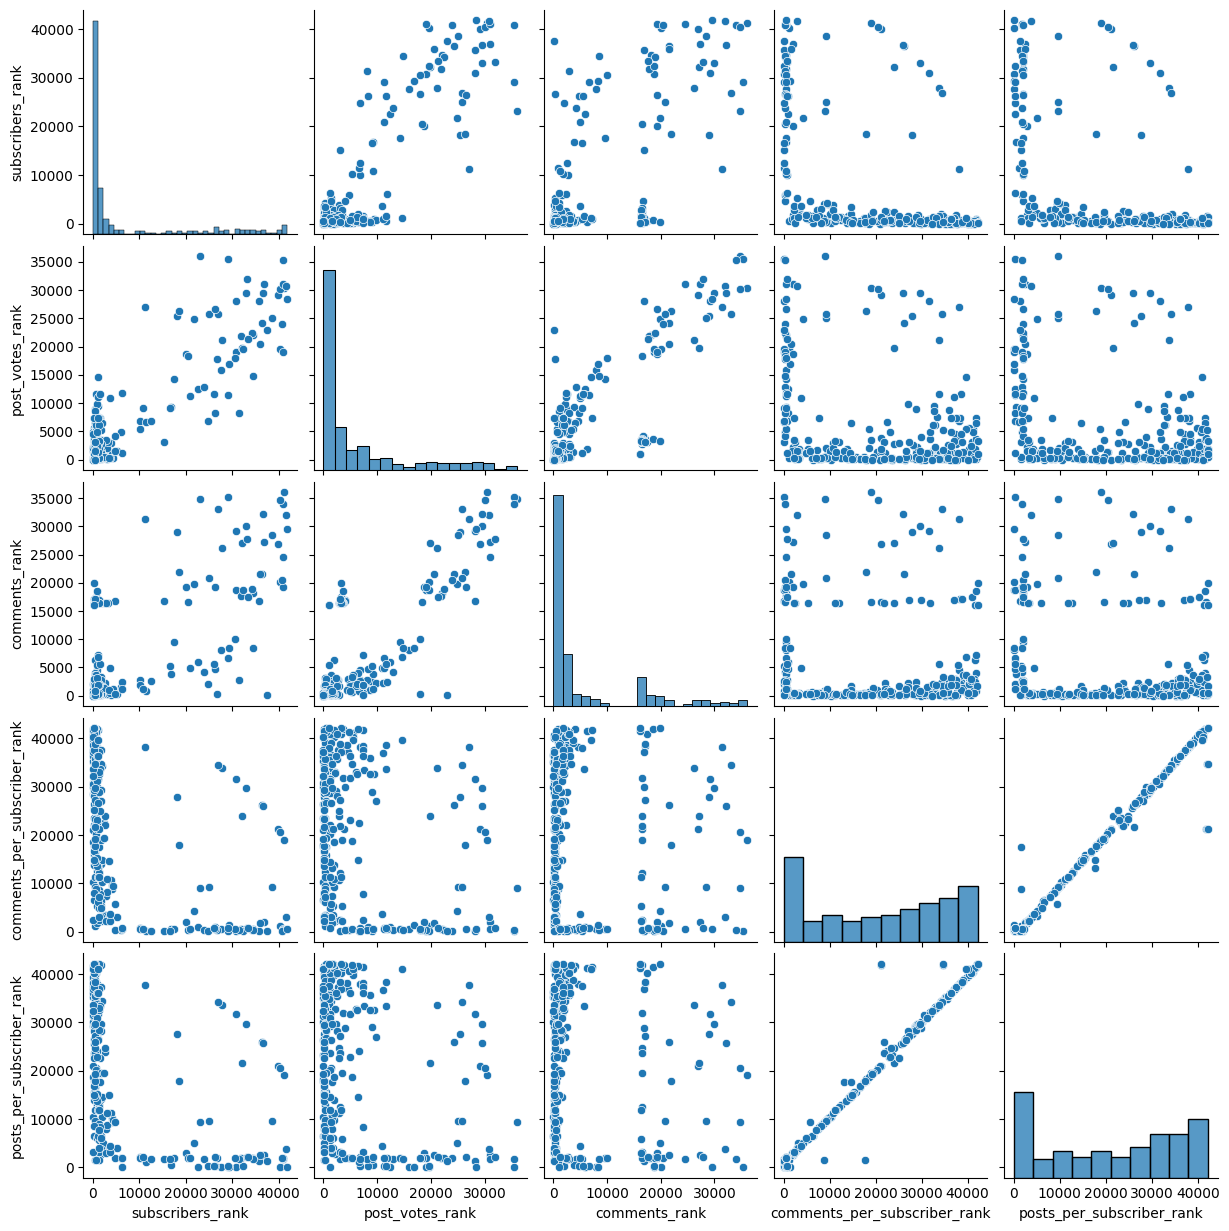

In [15]:
import seaborn as sns

rank_columns = [col for col in final_df.columns if 'rank' in col]
final_df.loc[:, rank_columns].corr()

sns.pairplot(final_df.loc[:, rank_columns])


In [16]:
num_columns = [col for col in final_df.columns if 'number' in col]
final_df.loc[:, num_columns].corr()

,subscribers_number,post_votes_number,comments_number,comments_per_subscriber_number,posts_per_subscriber_number
subscribers_number,1.000000,0.629444,0.563335,-0.133181,-0.027735
post_votes_number,0.629444,1.000000,0.703379,-0.134861,-0.030584
comments_number,0.563335,0.703379,1.000000,-0.093889,-0.037271
comments_per_subscriber_number,-0.133181,-0.134861,-0.093889,1.000000,0.048381
posts_per_subscriber_number,-0.027735,-0.030584,-0.037271,0.048381,1.000000


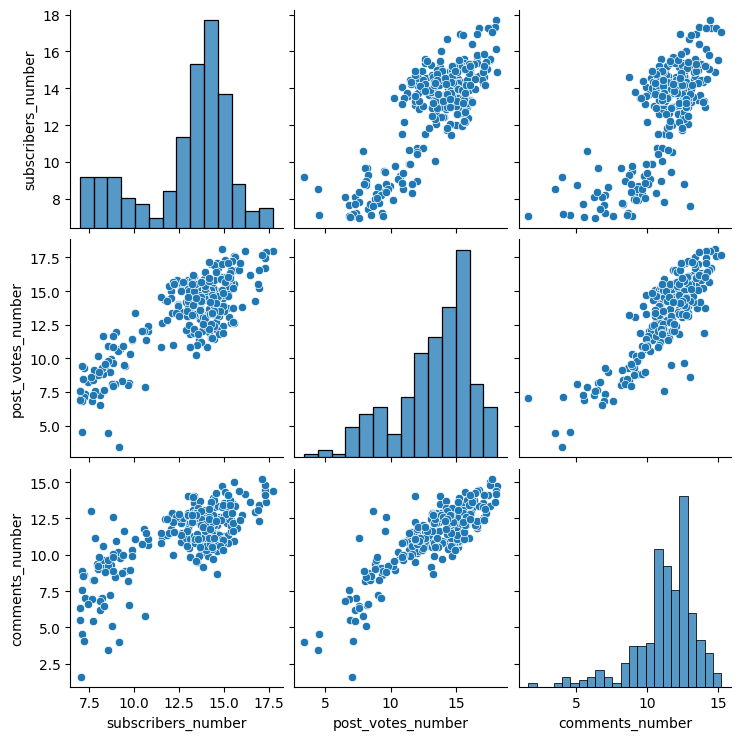

In [17]:
# what data to 
import seaborn as sns

number_cols = ['subscribers_number', 'post_votes_number', 'comments_number']

rank_cols = ['comments_per_subscriber_rank', 'posts_per_subscriber_rank', 'post_votes_rank']

df_numbers = final_df.loc[:, number_cols]

for c in df_numbers.columns:
    df_numbers[c] = np.log(df_numbers[c])

df_numbers.describe()

sns.pairplot(df_numbers)

df_numbers.to_csv('numbers.csv', index=False)


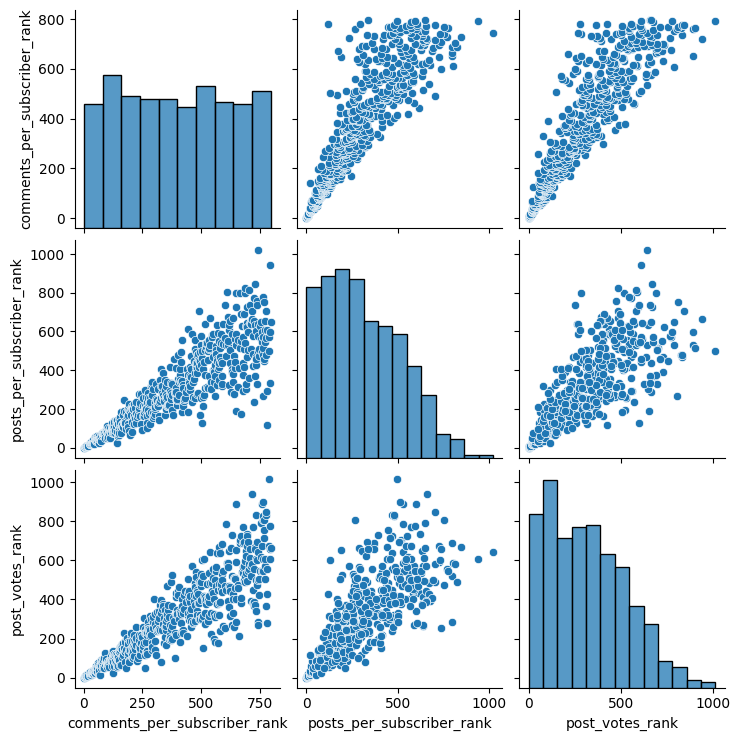

In [22]:
rank_cols = ['comments_per_subscriber_rank', 'posts_per_subscriber_rank', 'post_votes_rank']
df_ranks = final_df.loc[:, rank_cols]
sns.pairplot(df_ranks)
sns.pairplot(df_ranks)

In [23]:
# save the results as needed
df_ranks.to_csv('ranks.csv', index=False)

# Scores of comments: The subreddit dataset

In [24]:
# first let's read the data
scores = pd.read_csv('comments.csv', encoding='latin', usecols=[0, 2,3])

# make sure the scores are in absolute value
scores['score'] = np.abs(scores['score']) 

scores.to_csv('scores_modified.csv', index=False)


In [25]:
SUB_REDDIT = 'subreddit'
subs = list(scores[SUB_REDDIT].value_counts().index)
subs

['gameofthrones',
 'aww',
 'memes',
 'soccer',
 'freefolk',
 'MortalKombat',
 'todayilearned',
 'apexlegends',
 'asoiaf',
 'Market76',
 'Animemes',
 'FortNiteBR',
 'nfl',
 'trashy',
 'unpopularopinion',
 'ChapoTrapHouse',
 'RoastMe',
 'Showerthoughts',
 'wallstreetbets',
 'marvelstudios',
 'pics',
 'funny',
 'AskReddit',
 'gaming',
 'news',
 'politics',
 'dankmemes',
 'relationship_advice',
 'nba',
 'worldnews',
 'AmItheAsshole',
 'movies',
 'SquaredCircle',
 'The_Donald',
 'leagueoflegends',
 'hockey',
 'videos',
 'teenagers',
 'gonewild',
 'Pikabu']

In [26]:
# let's find the scores of 25k comments for each of the subreddits
scores_per_subreddit = {}
for _, row in scores.iterrows():
    if row[SUB_REDDIT] not in scores_per_subreddit:
        scores_per_subreddit[row[SUB_REDDIT]] = []
    scores_per_subreddit[row[SUB_REDDIT]].append(row['score'])

# sort them 
for subreddit, scores in scores_per_subreddit.items():
    scores_per_subreddit[subreddit] = sorted(scores,reverse=True)

In [28]:
def get_portions(x: list, ratio: int):
    # set the size of the portion
    portion_size = int ((len(x) * ratio) / 100)
    total = sum(x)
    return [sum(x[i: i + portion_size]) / total for i in range(0, len(x), portion_size)]


portions = [(s, get_portions(scores, ratio=2.5)) for s, scores in scores_per_subreddit.items()]       

# make a pdf out of it
comments_scores_distributions = pd.DataFrame(data=dict(portions))
for c in comments_scores_distributions.columns:
    comments_scores_distributions[c] = comments_scores_distributions[c]  * 100

In [29]:
comments_scores_distributions.reset_index(inplace=True)
comments_scores_distribution = comments_scores_distributions.rename(columns={"index": 'percentile'})
comments_scores_distribution['percentile'] += 1 
comments_scores_distribution['percentile'] *= 2.5 


In [30]:
# save the results to a dataframe
comments_scores_distribution.to_csv('scores_distributions.csv', index=False)

In [31]:
dist = comments_scores_distribution.copy()
dist.head()

,percentile,gameofthrones,aww,gaming,news,politics,dankmemes,relationship_advice,nba,worldnews,...,Animemes,FortNiteBR,nfl,trashy,unpopularopinion,ChapoTrapHouse,RoastMe,Showerthoughts,wallstreetbets,Pikabu
0,2.5,61.179938,70.260596,68.579403,71.128767,64.375475,63.244544,66.931745,56.105373,70.536345,...,49.330860,51.512761,46.140573,64.534975,55.048161,35.478060,78.978772,77.305916,48.767074,31.117662
1,5.0,8.743617,9.079106,7.875544,6.474838,7.187998,10.839437,7.428832,9.659151,6.121452,...,12.639074,9.741275,11.745789,8.530396,7.313969,12.803728,4.351285,5.914416,8.608123,12.371923
2,7.5,4.807384,4.535187,4.260438,3.713098,4.322794,5.577892,3.927409,5.250387,3.584831,...,7.641344,5.586478,7.124250,4.939197,4.590674,8.316375,2.064311,2.830639,5.210323,8.242553
3,10.0,3.181616,2.849295,2.775724,2.645208,3.144489,3.352698,2.666738,3.640953,2.630581,...,5.266735,4.002863,5.118722,3.448119,3.401208,6.245524,1.340088,1.745894,3.874048,6.157023
4,12.5,2.406799,1.992581,2.003687,2.046417,2.484409,2.188342,2.038618,2.809935,2.072857,...,3.891360,3.016757,3.931347,2.607868,2.818120,4.842830,0.945057,1.272690,3.150006,4.922970


In [32]:
df = dist[['percentile', 'aww']].copy()
df['subreddit'] = 'aww'
df.head()

,percentile,aww,subreddit
0,2.5,70.260596,aww
1,5.0,9.079106,aww
2,7.5,4.535187,aww
3,10.0,2.849295,aww
4,12.5,1.992581,aww


In [33]:
# let's create a version of the dataframe that can be used in TABLEAU FOR VISUALIZATION 

list_dfs =[dist[['percentile', c]].rename(columns={c: 'score_percentage'}) for c in dist.columns if c != 'percentile']
for i in range(len(list_dfs)):
    list_dfs[i]['subreddit'] = list(dist.columns)[i + 1]

# concatenate the whole thing
final_dist_df = pd.concat(list_dfs, ignore_index=True, axis=0)

   percentile  score_percentage      subreddit
0         2.5         61.179938  gameofthrones
1         5.0          8.743617  gameofthrones
2         7.5          4.807384  gameofthrones
3        10.0          3.181616  gameofthrones
4        12.5          2.406799  gameofthrones
   percentile  score_percentage subreddit
0         2.5         70.260596       aww
1         5.0          9.079106       aww
2         7.5          4.535187       aww
3        10.0          2.849295       aww
4        12.5          1.992581       aww
   percentile  score_percentage subreddit
0         2.5         68.579403    gaming
1         5.0          7.875544    gaming
2         7.5          4.260438    gaming
3        10.0          2.775724    gaming
4        12.5          2.003687    gaming
   percentile  score_percentage subreddit
0         2.5         71.128767      news
1         5.0          6.474838      news
2         7.5          3.713098      news
3        10.0          2.645208      news
4   

In [34]:
final_dist_df.shape

(1600, 3)

In [35]:
final_dist_df.to_csv('final_distributions.csv', index=False)

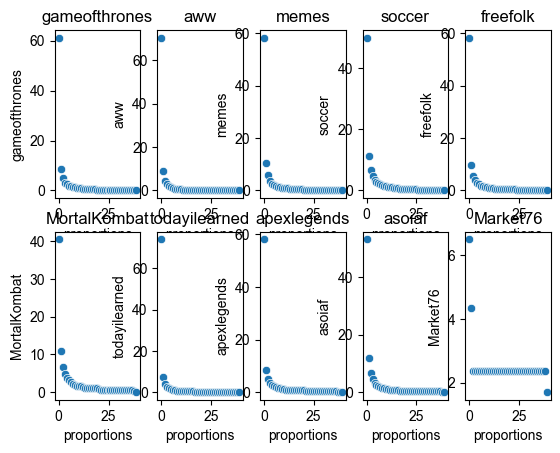

In [36]:
# we have 40 subreddits, let's consider 10 of them: 2 rows with 5 columns each
figure, axis = plt.subplots(2, 5)

sns.set(rc = {'figure.figsize':(12,  12)})

for i, s in enumerate(subs[:10]):
    sns.scatterplot(data=comments_scores_distributions.reset_index(), y=s, x='index', ax=axis[i // 5, i % 5])
    axis[i // 5, i % 5].set_title(s)
    axis[i // 5, i % 5].set_xlabel('proportions')
    
  
# Combine all the operations and display
plt.show()

In [37]:
pd.read_csv('results.csv')

,approach,ndcg
0,classification,0.4471
1,classification_with_topics,0.4456
2,reward_model,0.8955
